In [1]:
# loading the python NWB API
import pynwb, os, sys
import numpy as np # numpy for numerical analysis
import matplotlib.pylab as plt # + matplotlib for vizualization

from datavyz import ge
from physion.dataviz.show_data import MultimodalData 
from physion.analysis.read_NWB import scan_folder_for_NWBfiles, DummyParent, read

## Setting the datafolder

In [2]:
FILES, DATES, SUBJECTS = scan_folder_for_NWBfiles(os.path.join(os.path.expanduser('~'), 'DATA', 'fichiers.nwb'))
print('Subjects: ')
for s in np.unique(SUBJECTS):
    print(' -', s)

inspecting the folder "/home/yann/DATA/fichiers.nwb" [...]
 -> found n=56 datafiles 
Subjects: 
 - Mouse1_SSTCreEphys
 - Mouse1_SSTCreTdTomato
 - Mouse2_SSTCreEphys
 - Mouse2_SSTCreTdTomato
 - Mouse3_SSTCreEphys


## Single Recording Analysis

In [3]:

def summary_figure(filename, mouse_name = None, tzoom=[100,120],
                   running_speed_threshold=0.1,
                   median_facemotion_factor=3,
                   eye_movement_threshold=0.1,
                   pupil_threshold=1.2):
    
    data = MultimodalData(filename)

    if mouse_name is None:
        mouse_name = data.nwbfile.subject.subject_id

    # build full figure
    fig, AX = ge.figure(axes_extents=[[[4,1]],[[4,2]],[[1,1],[1,1],[1,1],[1,1]]], wspace=1.5)
    [ax_full], [ax_zoom], [ax_runningHist, ax_facemvtHist, ax_pupilHist, ax_eyePos] = AX
    
    # running
    ge.hist(data.nwbfile.acquisition['Running-Speed'].data[:], ax=ax_runningHist)

    # full view settings
    plot_settings_full = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=10)},'Tbar':20}
    plot_settings_zoom = {'settings':{'Locomotion':dict(fig_fraction=1, subsampling=1)},'Tbar':1}
    
    # whisking
    if 'FaceMotion' in data.nwbfile.processing:
        ge.hist(1e-3*data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:], ax=ax_facemvtHist)
        plot_settings_full['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=10)
        plot_settings_zoom['settings']['FaceMotion'] = dict(fig_fraction=1, subsampling=1)
    else:
        ge.annotate(ax_facemvtHist, 'absent', (0.5, 0.5), ha='center', va='center', size='small')

    # pupil
    if 'Pupil' in data.nwbfile.processing:
        cond = np.isfinite(data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:])
        diameter = np.max([data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[cond],
                data.nwbfile.processing['Pupil'].data_interfaces['sy'].data[cond]], axis=0)
        ge.hist(diameter, ax=ax_pupilHist)
        # eye position
        x = data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond][::10]
        y = data.nwbfile.processing['Pupil'].data_interfaces['cy'].data[cond][::10]
        ge.scatter(x-x.mean(),y-y.mean(), ax=ax_eyePos, color=ge.orange, ms=1)
        ge.plot([-eye_movement_threshold, +eye_movement_threshold, +eye_movement_threshold, -eye_movement_threshold, -eye_movement_threshold],
                [-eye_movement_threshold, -eye_movement_threshold, +eye_movement_threshold, +eye_movement_threshold, -eye_movement_threshold],
                ax=ax_eyePos, color='k', no_set=True)
        
        plot_settings_full['settings']['Pupil'] = dict(fig_fraction=1, subsampling=10)
        plot_settings_zoom['settings']['Pupil'] = dict(fig_fraction=1, subsampling=1)

    ge.annotate(fig, mouse_name+'  -- '+filename, (1,1), va='top', ha='right', size='small')

    # full view
    _ = data.plot_raw_data(data.tlim, ax=ax_full, **plot_settings_full)
    ge.annotate(ax_full, 'full recording', (1,1), ha='right', va='top', size='large')
    ax_full.fill_between(tzoom, ax_full.get_ylim()[0]*np.ones(2), ax_full.get_ylim()[1]*np.ones(2),
                        color='gray', alpha=.2, lw=0)
    # zoom
    ge.annotate(ax_zoom, 'zoom', (1,1), ha='right', va='top', size='large')
    _ = data.plot_raw_data(tzoom, ax=ax_zoom, **plot_settings_zoom)

    ge.set_plot(ax_runningHist, yticks=[], ylabel='count (norm.)', xlabel='speed (cm/s)', title='running')
    ge.set_plot(ax_facemvtHist, yticks=[], ylabel='count (norm.)', xlabel='motion (a.u.)', title='facemotion')
    ge.set_plot(ax_pupilHist, ylabel='count (norm.)', xlabel='diam. (mm)', title='pupil')
    ge.set_plot(ax_eyePos, xlabel='$\delta$x (mm)', ylabel='$\delta$y (mm)', title='eye position', yscale='lin')

    ax_runningHist.plot(np.ones(2)*running_speed_threshold, ax_runningHist.get_ylim(), ':', color=ge.blue)
    ax_facemvtHist.plot(np.ones(2)*median_facemotion_factor*np.median(data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:]),
                        ax_facemvtHist.get_ylim(), ':', color=ge.purple)
    ax_pupilHist.plot(np.ones(2)*pupil_threshold, ax_pupilHist.get_ylim(), ':', color=ge.red)

    
    # close datafile
    data.io.close()
    return fig, AX

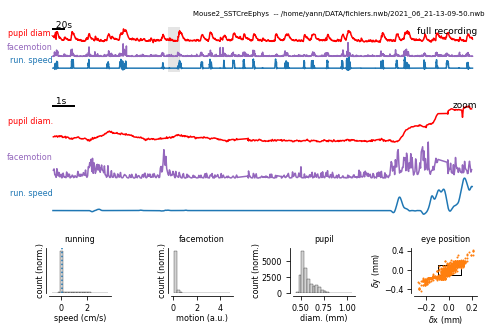

In [4]:
fig, AX = summary_figure(FILES[0], tzoom=[200,220])
#ge.save_on_desktop(fig, 'fig.png')

In [5]:
class Parent:
    def __init__(self):
        pass

def analysis(filename,
             running_speed_threshold=0.1,
             pupil_diam_threshold=1.,
             eye_movement_threshold=0.1,
             median_facemotion_factor=3):
    
    data, output = Parent(), {}
    read(data, filename)

    # session duration
    output['session-duration'] = (data.tlim[1]-data.tlim[0])/60. # in min.
    
    # running
    y = data.nwbfile.acquisition['Running-Speed'].data[:]
    running_cond = (y>running_speed_threshold)
    output['percent-running'] = 100.*np.sum(running_cond)/len(y)
    output['percent-negative-running'] = 100*np.sum(y<0)/len(y)
    output['mean-running-speed'] = np.mean(y[running_cond])
    
    # facemotion
    if 'FaceMotion' in data.nwbfile.processing:
        y = data.nwbfile.processing['FaceMotion'].data_interfaces['face-motion'].data[:]
        facemotion_cond = y>median_facemotion_factor*np.median(y)
        output['percent-facemotion'] = 100*np.sum(facemotion_cond)/len(y)
        output['mean-facemotion'] = 1e-3*np.mean(y[facemotion_cond])
    else:
        facemotion_cond = None
        output['percent-facemotion'] = np.inf
        output['mean-facemotion'] = np.inf

    # pupil
    if 'Pupil' in data.nwbfile.processing:
        cond = np.isfinite(data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[:])
        diameter = np.max([data.nwbfile.processing['Pupil'].data_interfaces['sx'].data[cond],
                data.nwbfile.processing['Pupil'].data_interfaces['sy'].data[cond]], axis=0)
        output['mean-pupil'] = np.mean(diameter)
        high_pupil_cond = (diameter>pupil_diam_threshold)
        output['percent-high-pupil'] = 100*np.sum(high_pupil_cond)/len(y)
        if np.sum(high_pupil_cond)>0:
            output['mean-high-pupil'] = np.mean(diameter[high_pupil_cond])
        else:
            output['mean-high-pupil'] = np.inf
        x0 = np.mean(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond])
        y0 = np.mean(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond])
        eye_mov_cond = (np.abs(data.nwbfile.processing['Pupil'].data_interfaces['cx'].data[cond]-x0)>eye_movement_threshold) & \
            (np.abs(data.nwbfile.processing['Pupil'].data_interfaces['cy'].data[cond]-y0)>eye_movement_threshold)
        output['percent-eye-mov'] = 100*np.sum(eye_mov_cond)/len(eye_mov_cond)
    else:
        high_pupil_cond = None
        output['mean-pupil'] = np.inf
        output['mean-high-pupil'] = np.inf
        output['percent-high-pupil'] = np.inf
        output['percent-eye-mov'] = np.inf

    # overlap
    # [...]

    data.io.close()
    return output

output = analysis(FILES[3])
print(output)
    

{'session-duration': 10.174666666666667, 'percent-running': 6.421176778928056, 'percent-negative-running': 2.4636351723234178, 'mean-running-speed': 1.4166026483859622, 'percent-facemotion': 12.978771200718858, 'mean-facemotion': 0.43550372999812637, 'mean-pupil': 0.4422601529833199, 'percent-high-pupil': 0.0, 'mean-high-pupil': inf, 'percent-eye-mov': 0.14600999606896164}


## Population Analysis of the Habituation Process

# Summary figure

In [6]:
STARTING_DATES = {'Mouse1_SSTCreTdTomato':'2021_06_08',
                  'Mouse2_SSTCreTdTomato':'2021_06_08',
                  'Mouse1_SSTCreEphys':'2021_06_08',
                  'Mouse2_SSTCreEphys':'2021_06_08',
                  'Mouse3_SSTCreEphys':'2021_06_08'}


inspecting the folder "/home/yann/DATA/fichiers.nwb" [...]
 -> found n=56 datafiles 
Mouse1_SSTCreEphys 2021_06_10


/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Mouse1_SSTCreTdTomato 2021_06_09
Mouse2_SSTCreEphys 2021_06_16
Mouse2_SSTCreTdTomato 2021_06_10


/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/yann/miniconda3/envs/physion/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


Mouse3_SSTCreEphys 2021_06_10


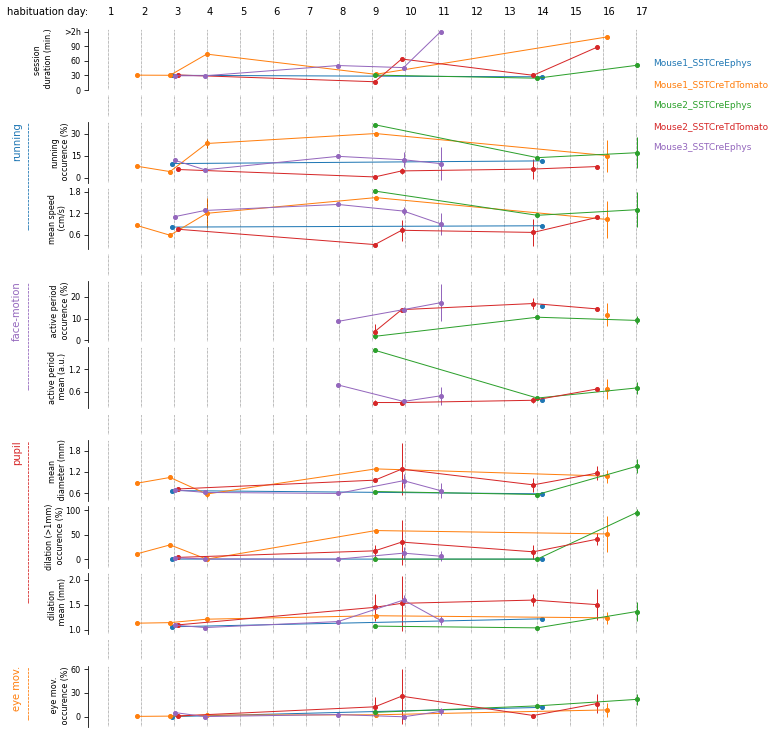

In [7]:
axes_extent=[[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]],
             [[1,2]],
             [[1,5]],[[1,5]],[[1,5]],
             [[1,2]],
             [[1,5]]]


def days_per_months(month):
    if month in [2,4,6,9,11]:
        return 30
    else:
        return 31
    
def datestring_to_int(day):
    y, m, d = day.split('_')
    return int(y)*31*12+days_per_months(int(m))+int(d)
    

FILES, DATES, SUBJECTS = scan_folder_for_NWBfiles(os.path.join(os.path.expanduser('~'), 'DATA', 'fichiers.nwb'))
fig, AX = ge.figure(axes_extents=axes_extent, figsize=(3,.18), hspace=1., left=1., bottom=0., top=10., right=3.)

KEYS = ['percent-running', 'percent-negative-running', 'mean-running-speed', 'percent-facemotion',\
        'mean-facemotion', 'mean-pupil', 'percent-high-pupil', 'mean-high-pupil', 'percent-eye-mov', 'session-duration']
day_max = 0
for iS, s in enumerate(np.unique(SUBJECTS)):
    condS = (SUBJECTS==s)
    # re-init results
    results = {}
    for key in KEYS:
        results[key] = {'day':[], 'val':[], 'sval':[]}
    # looping over datafiles
    files, dates = FILES[condS], np.array([datestring_to_int(d) for d in DATES[condS]])
    print(s, DATES[condS][np.argmin(dates)])
    for d in np.unique(dates):
        results2, tshift = {}, .1*np.random.randn()
        for key in KEYS:
            results2[key] = {'day':[], 'val':[]}
        dCond = (dates==d)
        for ifile, dDay in enumerate(dates[dCond]):
            if s in STARTING_DATES:
                ndate = dDay-datestring_to_int(STARTING_DATES[s])+1
            else:
                ndate = dDay-dates.min()+1
            cell = analysis(files[dCond][ifile])
            for key in cell:
                if np.isfinite(cell[key]):
                    results2[key]['day'].append(ndate)
                    results2[key]['val'].append(cell[key])
        for key in KEYS[:-1]:
            results[key]['day'].append(np.mean(results2[key]['day'])+tshift)
            results[key]['val'].append(np.mean(results2[key]['val']))
            results[key]['sval'].append(np.std(results2[key]['val']))
        results['session-duration']['day'].append(ndate+tshift)
        tfull = np.min([np.sum(results2['session-duration']['val']), 120])
        results['session-duration']['val'].append(tfull)
        results['session-duration']['sval'].append(0)
        day_max = np.max([day_max, ndate])
    # plotting
    for ax, key in zip([AX[0],
                        AX[2], AX[3],
                        AX[5], AX[6],
                        AX[8], AX[9], AX[10],
                        AX[12]],
                        ['session-duration',
                         'percent-running', 'mean-running-speed',
                         'percent-facemotion', 'mean-facemotion',
                         'mean-pupil', 'percent-high-pupil', 'mean-high-pupil',
                         'percent-eye-mov']):
        ge.scatter(results[key]['day'], results[key]['val'], sy=results[key]['sval'], color=ge.tab10(iS), lw=1, no_set=True, ax=ax, ms=4)
    ge.annotate(AX[0], iS*'\n\n'+s, (1., .5), ha='left', va='top', color=ge.tab10(iS), size='large')

for i in [1, 4, 7, 11]:
    AX[i].axis('off')
    AX[i].set_ylim([0, 1])
for i, label, color, dy in zip([2, 5, 8, 12], ['running', 'face-motion', 'pupil', 'eye mov.'], ['blue', 'purple', 'red', 'orange'], [30, 30, 45, 15]):
    ge.annotate(AX[i], label + 6*'\n', (0, 1), va='top', ha='right', rotation=90, color=getattr(ge, color), size='x-large')
    ge.annotate(AX[i], dy*'-'+5*'\n', (0, 1), va='top', ha='right', rotation=90, color=getattr(ge, color), size='x-large')

i=0
ge.set_plot(AX[0], ['left'], ylabel='session \n duration (min.)\n', yticks=[0, 30, 60, 90, 120], yticks_labels=['0', '30', '60', '90', '>2h'])
i+=2
ge.set_plot(AX[i], ['left'], ylabel='running\n occurence (%)')
ge.set_plot(AX[i+1], ['left'], ylabel='mean speed\n (cm/s)')
i+=3
ge.set_plot(AX[i], ['left'], ylabel=' active period \n occurence (%)')
ge.set_plot(AX[i+1], ['left'], ylabel='active period\n mean (a.u.)')
i+=3
ge.set_plot(AX[i], ['left'], ylabel='mean \n diameter (mm)')
ge.set_plot(AX[i+1], ['left'], ylabel='dilation (>1mm)\n occurence (%)')
ge.set_plot(AX[i+2], ['left'], ylabel='dilation \n mean (mm)')
i+=4
ge.set_plot(AX[i], ['left'], ylabel=' eye mov.\n occurence (%)')

for i in range(1, day_max+1):
    for ax in AX:
        ax.plot(i*np.ones(2), ax.get_ylim(), 'k:', lw=0.5)
    ge.annotate(AX[0], '%i\n' % i, (i, AX[0].get_ylim()[1]), xycoords='data', size='x-large')
for ax in AX:
    ax.set_xlim([0.5, day_max+.5])
ge.annotate(AX[0], 'habituation day: \n', (0, 1.), ha='right', size='x-large')
ge.save_on_desktop(fig, 'fig.png')